# face_detection.ipynb
__Author:__ Matthew Lesko-Krleza<br>
__Course:__ ECSE 415<br>
__Assignment:__ Assignment #4 Face Detection<br>
__Due Date:__ November 22nd 2018

In [16]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

#### Question 1. Data Acquisition

In [2]:
DIRECTORY = './dataset/'
SIZE = (100, 100)
N_FACES = 30

evans, hemsw, johan = [], [], []
group = None
images = os.listdir(DIRECTORY)

for i in range(len(images)):
    name = images[i]
    img = cv2.imread(DIRECTORY + name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if 'evans' in name:
        img = cv2.resize(img, SIZE)
        evans.append(img)
    elif 'hemsworth' in name:
        img = cv2.resize(img, SIZE)
        hemsw.append(img)
    elif 'johansson' in name:
        img = cv2.resize(img, SIZE)
        johan.append(img)
    elif 'group' in name:
        group = img
    else:
        print('Wrong image name: ', name)

Figure 1. Training Images:


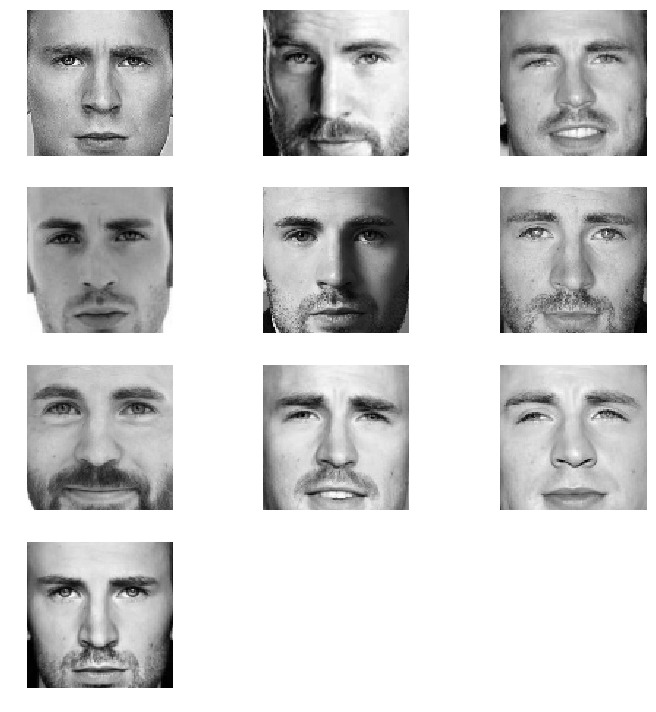

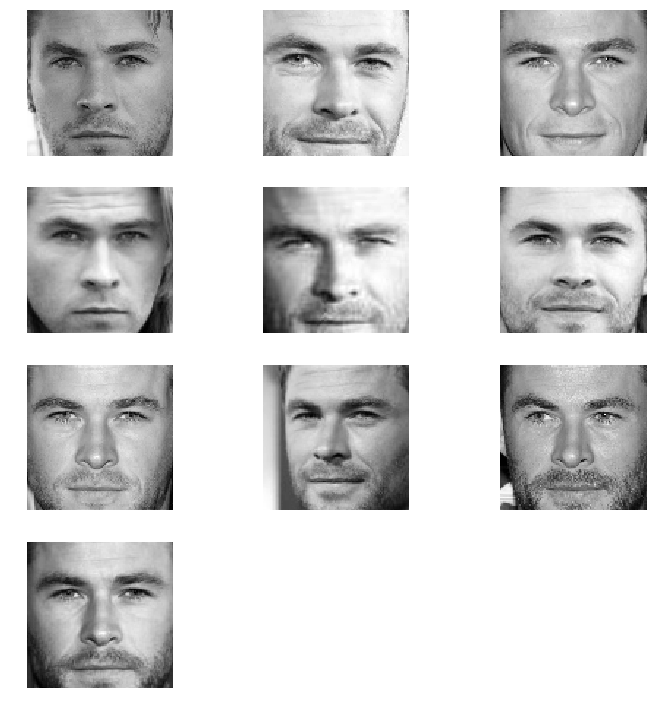

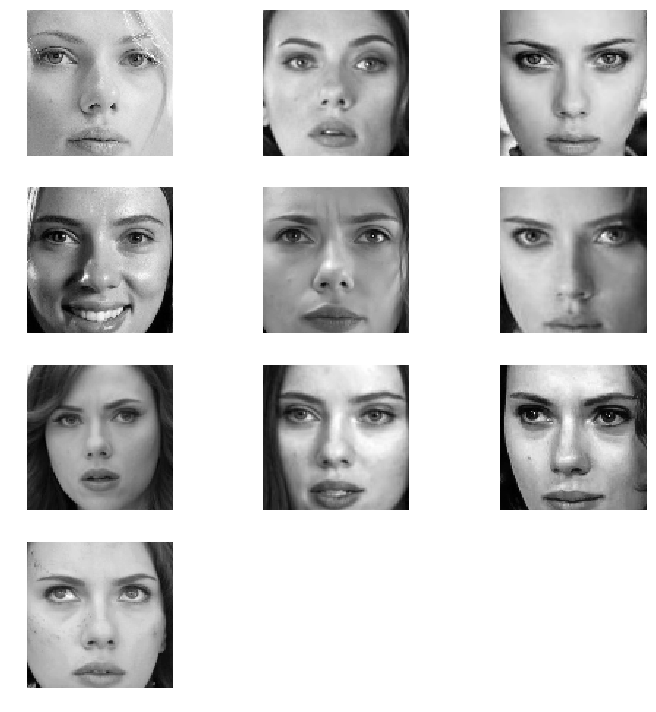

Figure 2. Test Image:


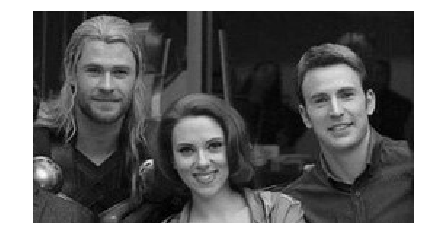

In [3]:
print('Figure 1. Training Images:')
plt.figure(figsize=(10,10))
for i in range(len(evans)):
    plt.subplot(4, 3, i + 1)
    plt.imshow(evans[i], "gray")
    plt.axis('off')
    plt.tight_layout()
plt.figure(figsize=(10,10))
for i in range(len(hemsw)):
    plt.subplot(4, 3, i + 1)
    plt.imshow(hemsw[i], "gray")
    plt.axis('off')
    plt.tight_layout()
plt.figure(figsize=(10,10))
for i in range(len(johan)):
    plt.subplot(4, 3, i + 1)
    plt.imshow(johan[i], "gray")
    plt.axis('off')
    plt.tight_layout()
plt.show()

print('Figure 2. Test Image:')
plt.subplot(1, 1, 1)
plt.imshow(group, "gray")
plt.axis('off')
plt.tight_layout()
plt.show()

I've chosen the group photo as seen in Figure 2, because the test faces are well illuminated and are facing towards the camera. I've chosen to use the 30 training images as seen in Figure 1, because the subjects' faces are well illuminated and facing towards the camera. There are a few training images that include a shadow on the subject's face. This would help create a more robust predictor for the respective faces. The training faces are also all of similar scale. I've set all the images to grayscale for simpler computation; there is only one dimensional variable to consider instead of 3.

I've also resized the training images to 100 x 100 pixels. This results in 10_000 dimensional vectors to be used, hence decreasing the initial face space size. Increasing the computation speed.

#### Question 2. Eigenvector Representation

__Question 2.1:__ Use PCA to find eigenvector representation of your training data (5 Points)

In [4]:
N_COMPONENTS = 30

# We desire a vector intensity representation of the images, hence we flatten the matrices
evans_flat = [v.flatten() for v in evans]
hemsw_flat = [v.flatten() for v in hemsw]
johan_flat = [v.flatten() for v in johan]

X = np.array([*evans_flat, *hemsw_flat, *johan_flat])
Y = np.concatenate(([0 for x in range(10)], [1 for x in range(10)], [2 for x in range(10)]))
text = np.array(['Evans', 'Hemsworth', 'Johannson'])

pca = PCA(n_components=N_COMPONENTS)
X_train_pca = pca.fit_transform(X)

eigenvectors = pca.components_
variances = pca.explained_variance_

Figure 3: Eigenvector Representation of Training Data (Sorted from greatest variance to lowest):


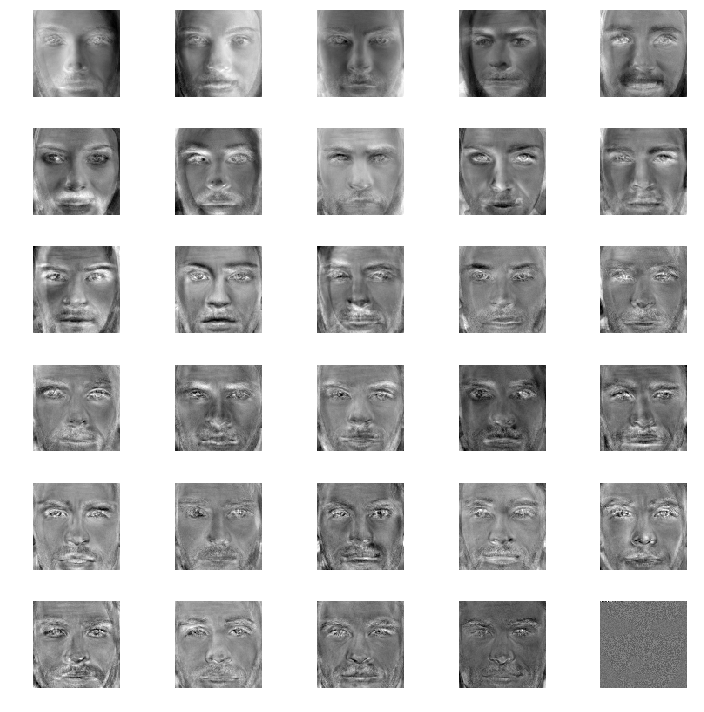

In [5]:
print('Figure 3: Eigenvector Representation of Training Data (Sorted from greatest variance to lowest):')
plt.figure(figsize=(10,10))
for index, eigenvector in enumerate(eigenvectors):
    plt.subplot(6, 5, index + 1)
    plt.imshow(eigenvector.reshape(SIZE), cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

__Question 2.2:__ Plot the variance explained by every vector in descending order (2 Points)

Figure 4: Variance vs Principal Components Plots


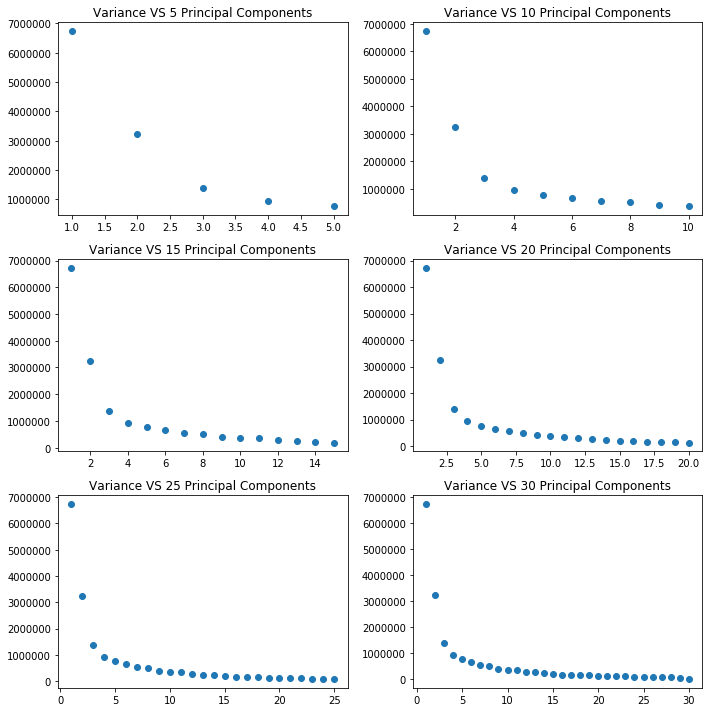

In [6]:
print('Figure 4: Variance vs Principal Components Plots')
plt.figure(figsize=(10,10))
for plot_n in range(0, 6):
    plt.subplot(3, 2, plot_n + 1)
    n_components = (plot_n + 1) * 5
    plt.scatter([x for x in range(1, n_components + 1)], variances[:n_components])
    plt.title(str.format('Variance VS {} Principal Components', n_components))
plt.tight_layout()
plt.show()

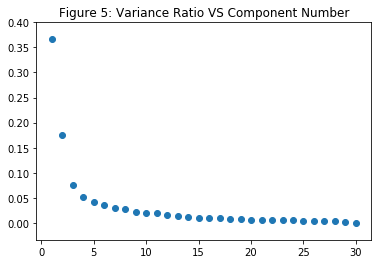

In [9]:
variance_ratios = pca.explained_variance_ratio_
plt.scatter([x for x in range(1, 31)], variance_ratios)
plt.title('Figure 5: Variance Ratio VS Component Number')
plt.show()

In [10]:
print('Variance Ratios:')
print(*['\n\t' + str(x) for x in variance_ratios])

Variance Ratios:

	0.3663056703658452 
	0.1762063425564165 
	0.07560055503935893 
	0.05099703010421181 
	0.041620789023012195 
	0.03555656447012514 
	0.030046009065444603 
	0.027729845654364878 
	0.02180582753106544 
	0.019733624399566514 
	0.018980255284303617 
	0.015549251019371359 
	0.014034187638029712 
	0.012347650183152474 
	0.010287319456126728 
	0.009401738839986648 
	0.009081868783974347 
	0.00839443964484233 
	0.007566710723085919 
	0.0069142356069257305 
	0.006441851528734576 
	0.006192672921798909 
	0.005781074864971666 
	0.005095247451286948 
	0.004736014130731021 
	0.0039700506463184 
	0.0038084708972281507 
	0.00327801828564287 
	0.002536683884077433 
	7.224105567809755e-32


__Question 2.3:__ Do you need all the vectors to represent the data? (3 Points)

The greater the variance, the lower the square modeling error. So as a designer, I'd like to try to find the vectors that maximize the variance of my data. As described in the lecture slides, this problem can be simplified to an eigenvalue/eigenvector problem. One can see in Figure #5, we only really need a subset of the eigenvectors to represent the data. The first 9 eigenvectors would suffice. Their total variance ratio would be of roughly 0.84.

In [78]:
np.sum(variance_ratios[0:10])

0.8456022582094113

__Question 2.4:__ How well clustered is your data? (10 Points)

In [104]:
results = []
for index, sample in enumerate(X):
    
    # If delete is not done you'll always just get the index of that sample vector within the pixel space which wouldn't help analyze our data
    X_temp = np.delete(X, index, 0) - sample
    Y_temp = np.delete(Y, index)
    
    nearest_neighbor = np.argmin(np.linalg.norm(X_temp, axis=1))
    label = Y_temp[nearest_neighbor]
    results.append(label == Y[index])
    
    print('Prediction:\t', label, '\tActual:\t', Y[index])

print('\nNumber of Correct Predictions:\t\t', np.count_nonzero(results))
print('Nearest Neighbor Prediction Accuracy:\t', np.count_nonzero(results)/len(results))

Prediction:	 2 	Actual:	 0
Prediction:	 0 	Actual:	 0
Prediction:	 0 	Actual:	 0
Prediction:	 0 	Actual:	 0
Prediction:	 1 	Actual:	 0
Prediction:	 0 	Actual:	 0
Prediction:	 0 	Actual:	 0
Prediction:	 2 	Actual:	 0
Prediction:	 0 	Actual:	 0
Prediction:	 2 	Actual:	 0
Prediction:	 2 	Actual:	 1
Prediction:	 0 	Actual:	 1
Prediction:	 0 	Actual:	 1
Prediction:	 1 	Actual:	 1
Prediction:	 2 	Actual:	 1
Prediction:	 1 	Actual:	 1
Prediction:	 0 	Actual:	 1
Prediction:	 2 	Actual:	 1
Prediction:	 0 	Actual:	 1
Prediction:	 1 	Actual:	 1
Prediction:	 0 	Actual:	 2
Prediction:	 0 	Actual:	 2
Prediction:	 0 	Actual:	 2
Prediction:	 2 	Actual:	 2
Prediction:	 1 	Actual:	 2
Prediction:	 0 	Actual:	 2
Prediction:	 0 	Actual:	 2
Prediction:	 2 	Actual:	 2
Prediction:	 1 	Actual:	 2
Prediction:	 0 	Actual:	 2

Number of Correct Predictions:		 11
Nearest Neighbor Prediction Accuracy:	 0.36666666666666664


11/30 of my data has a neighbor of the same class.

In [124]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.99)

pca = PCA(n_components=9).fit(X)
eigenvectors = pca.components_

results = []
for index, sample in enumerate(X_test):
    
    sample = sample - pca.mean_.flatten()
    eigenface = np.zeros(SIZE).flatten()
    
    for eigenvector in eigenvectors:
        eigenface += np.dot(sample, eigenvector) * eigenvector
        
    nearest_neighbor = np.argmin(np.linalg.norm(eigenvectors - eigenface, axis=1))
    label = Y_test[nearest_neighbor]
    results.append(label == Y_test[index])
    
    print('Prediction:\t', label, '\tActual:\t', Y_test[index])

print('\nNumber of Correct Predictions:\t\t', np.count_nonzero(results))
print('Nearest Neighbor Prediction Accuracy:\t', np.count_nonzero(results)/len(results))

Prediction:	 0 	Actual:	 0
Prediction:	 0 	Actual:	 2
Prediction:	 1 	Actual:	 1
Prediction:	 1 	Actual:	 1
Prediction:	 0 	Actual:	 2
Prediction:	 0 	Actual:	 2
Prediction:	 2 	Actual:	 2
Prediction:	 1 	Actual:	 1
Prediction:	 1 	Actual:	 1
Prediction:	 1 	Actual:	 2
Prediction:	 2 	Actual:	 0
Prediction:	 0 	Actual:	 1
Prediction:	 2 	Actual:	 0
Prediction:	 2 	Actual:	 1
Prediction:	 2 	Actual:	 2
Prediction:	 2 	Actual:	 2
Prediction:	 2 	Actual:	 0
Prediction:	 2 	Actual:	 2
Prediction:	 2 	Actual:	 0
Prediction:	 0 	Actual:	 0
Prediction:	 1 	Actual:	 1
Prediction:	 2 	Actual:	 1
Prediction:	 1 	Actual:	 0
Prediction:	 2 	Actual:	 0
Prediction:	 0 	Actual:	 2
Prediction:	 1 	Actual:	 0
Prediction:	 1 	Actual:	 0
Prediction:	 0 	Actual:	 2
Prediction:	 1 	Actual:	 1
Prediction:	 2 	Actual:	 1

Number of Correct Predictions:		 12
Nearest Neighbor Prediction Accuracy:	 0.4


As one can see, predicting the face's class with the use of nearest neighbors within the eigenspace gives a higher result and uses only 9 eigenvectors. 

#### Question 3 Face Detection & Identification

In [273]:
group_faces = []
group_display = group.copy()
last_pos = np.array([0,0])

for x in range(group.shape[0] - SIZE[0]):
    for y in range(group.shape[1] - SIZE[1]):
        pos = np.array([x, y])
        window = group[x : x + SIZE[0], y : y + SIZE[1]]
        sample = window.flatten() - pca.mean_
        
        eigenface = np.zeros(SIZE).flatten()
        for eigenvector in eigenvectors:
            eigenface += np.dot(sample, eigenvector) * eigenvector
            
        error = np.linalg.norm(sample - eigenface)
        
        if np.linalg.norm(last_pos - pos) > 160 :
            cv2.rectangle(group_display, (x, y), (x+SIZE[0], y+SIZE[1]), (255,255,255), 1)
            last_pos = pos
            group_faces.append(window)

91


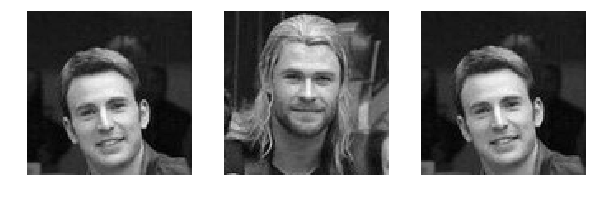

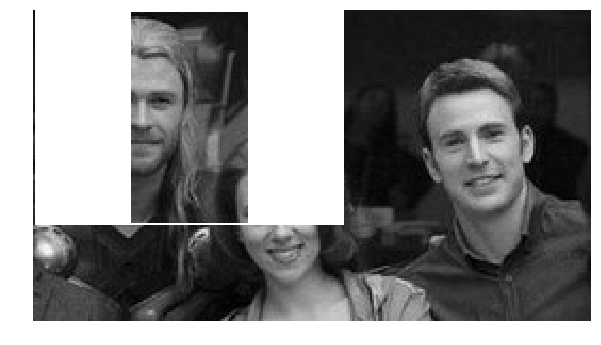

In [274]:
print(len(group_faces))
plt.figure(figsize=(10,10))
plt.subplot(131)
plt.imshow(group_faces[0], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(132)
plt.imshow(group_faces[1], cmap=plt.cm.gray)
plt.axis('off')
plt.subplot(133)
plt.imshow(group_faces[2], cmap=plt.cm.gray)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(group_display, cmap=plt.cm.gray)
plt.axis('off')
plt.show()

In [277]:
eigenvectors = pca.components_
results = []
Y_test = [0, 1]
X_test = np.array([group_faces[0], group_faces[1]])

for index, sample in enumerate(X_test):
    sample = sample.flatten() - pca.mean_.flatten()
    eigenface = np.zeros(SIZE).flatten()
    
    for eigenvector in eigenvectors:
        eigenface += np.dot(sample, eigenvector) * eigenvector
        
    nearest_neighbor = np.argmin(np.linalg.norm(eigenvectors - eigenface, axis=1))
    label = Y_test[nearest_neighbor]
    results.append(label == Y_test[index])
    
    print('Prediction:\t', label, '\tActual:\t', Y_test[index])

print('\nNumber of Correct Predictions:\t\t', np.count_nonzero(results))
print('Nearest Neighbor Prediction Accuracy:\t', np.count_nonzero(results)/len(results))

Prediction:	 0 	Actual:	 0
Prediction:	 0 	Actual:	 1

Number of Correct Predictions:		 1
Nearest Neighbor Prediction Accuracy:	 0.5


As one can see, my method doesn't work well. I have a multiple false positive as one can see in the group photo with the faces in rectangles. I also fail to recognize one of the faces.

#### Question 4 Viola-Jones Comparison

In [ ]:
lbp_face_cascade = cv2.CascadeClassifier(os.path.join('./', 'lbpcascade_frontalface.xml'))
img_faces_detected = cv2.cvtColor(group, cv2.COLOR_GRAY2RGB)

# detect faces
# detectMultiScape(image, scaleFactor, minNeighbors)
# scaleFactor - parameter specifying how much the image size is reduced
#  at each image scale
# minNeighbors - parameter specifying how many neighbors each candidate
#  rectangle should have to retain
lbp_faces = lbp_face_cascade.detectMultiScale(group, 1.1,2)
for (x,y,w,h) in lbp_faces:
    cv2.rectangle(img_faces_detected, (x,y), (x+w, y+h), (255,0,0), 2)

# display images
plt.figure(figsize=(15,15))
plt.imshow(img_faces_detected)
plt.title("Input Image"), plt.xticks([]), plt.yticks([])
plt.show()

PCA fails to work when the images from the dataset provided have little to no variance from one another or when the dataset is extremely small. The variance could be from lighting, and/or the angle of the face. A low variety would lead to an increase in prediction error. A small dataset would provide an inaccurate face space as well, making it harder to detect a face. However, Viola-Jones would work because all it requires to correctly identify a face is an image of a face where the eyes, nose bridge, and cheeks are clearly visible and aligned. This is because Viola-Jones uses Haar Cascade classifiers to identify the unique contrasts of lighting between the eyes, nose bridge, and cheeks.